# 1. Load libraries

In [1]:
import spotipy, pandas as pd
from spotipy.oauth2 import SpotifyOAuth
from sklearn import preprocessing as pre
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import seaborn as sns
from itertools import combinations, permutations
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# 2. Spotify authorization and some sample playlists to play around with

###### One playlist below is simply my Discover Weekly, for quickly testing to make sure the code works. The other is largely my Liked Songs, which contains songs from a variety of genres (movie soundtracks to rap and others), used to find the features on which to split. If you wish to play around with choosing features based on your own playlist, simply replace the playlist url below.

In [2]:
scope = 'playlist-modify-public playlist-modify-private'
red_url = 'http://localhost:8080'
#playlist = 'https://open.spotify.com/playlist/37i9dQZEVXcD0rEV1cHpue?si=cba0a3fd1e1a47b4' #Discover Weekly
playlist = 'https://open.spotify.com/playlist/0zZlkqz8ZRPsZd0kARwia9?si=2b1315ae6d884cb5' # big test playlist

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(redirect_uri=red_url,scope=scope))
user = sp.me()['id']

# 3. Song and feature extraction

##### sp.playlist_tracks returns json-formatted information about the songs in a playlist, up to 100 at a time
##### sp.audio_features returns json-formatted audio features about a list of songs, up to 50 at a time

In [3]:
offset = 0
song_ids = []
while True:
    songs = sp.playlist_tracks(playlist_id=playlist, offset=offset, fields='items.track.id', limit=100)['items']
    if len(songs) == 0:
        break
    song_ids += [d['track']['id'] for d in songs]
    offset += len(songs)

In [4]:
offset = 0
limit = 50
song_feats = []
while offset < len(song_ids):
    song_feats += sp.audio_features(tracks=song_ids[offset: offset + limit])
    offset += limit

In [5]:
df_feats = pd.DataFrame(song_feats).drop(['type', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'key', 'time_signature'], axis=1)

##### As a brief note, features already normed by Spotify like "energy" and "valence" are also normed below, as all songs spotify has being normed on these features does not guarantee an even distribution in the inputted playlist.

In [6]:
to_norm = df_feats[['loudness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'danceability', 'energy', 'valence']].values
scaler = pre.MinMaxScaler()
normed = scaler.fit_transform(to_norm)
df_normed = pd.DataFrame(normed).rename(columns={0: 'loudness', 1: 'tempo', 2: 'speechiness', 3: 'acousticness', 4: 'instrumentalness', 5: 'liveness', 6: 'danceability', 7: 'energy', 8: 'valence'})

In [7]:
df_feats.drop(['loudness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'danceability', 'energy', 'valence'], axis=1, inplace=True)

In [8]:
# We need the dataframe with the ids preserved later for playlist creation, and create one with song ids as the index for purposes of clustering
df_total = df_feats.join(df_normed)
df_feats = df_total.set_index('id')

# 4. Choosing features to cluster on

##### We create a heatmap of correlations below. Keeping in mind some of the stronger correlations, like loudness and instrumentalness or acousticness and energy, is important when choosing features in order to avoid clustering using those feature combinations. Also of note is mode's essentialy non-existant correlation with other features; this makes sense, as whether the key of a song is major or minor does not predict if it is instrumental  or loud, for example.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


<AxesSubplot:>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


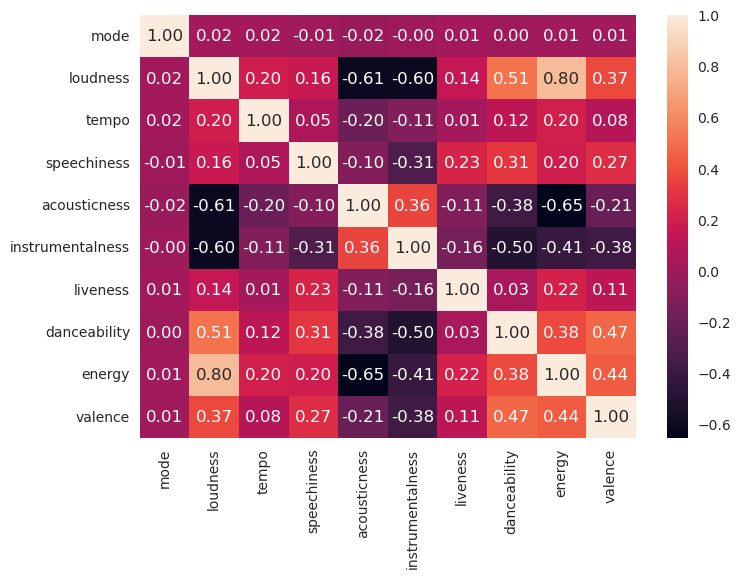

In [9]:
sns.heatmap(df_feats.corr(), annot=True, fmt='.2f')

##### The code below tests all possible combinations of audio features, running each with 2-6 clusters, in order to see the optimal elbow scores and corresponding silhouette scores for each.

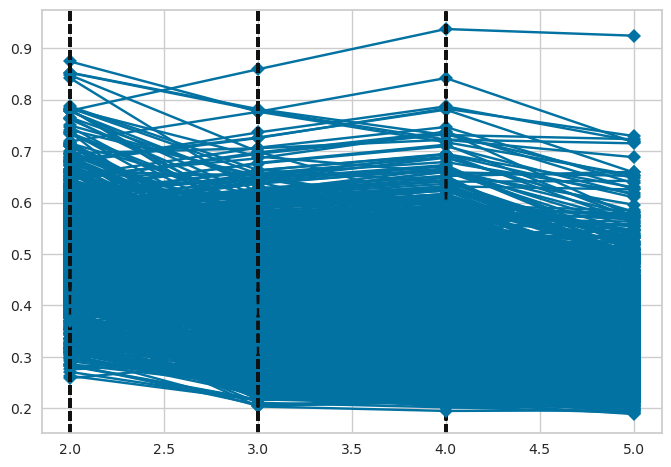

In [10]:
n_clusters = [2, 3, 4, 5, 6]
cols = list(df_feats)
feats = 2
combo, score, value = [], [], []
while feats <= len(cols):
    combos = list(combinations(cols, feats))
    combo += combos
    for comb in combos:
        subset = df_feats[list(comb)]
        model = KElbowVisualizer(KMeans(), k=(min(n_clusters), max(n_clusters)), metric='silhouette', timings=False)
        model.fit(subset.values)
        score.append(model.elbow_score_)
        value.append(model.elbow_value_)
    feats += 1
    
output = {'combo': combo, 'score': score, 'elbow': value}
df_combos = pd.DataFrame(output)

##### Below we output the top 10 feature combinations with silhouette scores above 0.6 and that have at least 3 clusters. We expect at least 3 clusters in order to avoid models that split primarily on one feature, i.e. grouping all songs in major keys in one cluster and all songs with a minor key in another.

##### As we can see below, clustering based on only mode and instrumentalness scored extremely highly. These two features appeared in the top 8 best scoring models; some of these models, like the second-best-performing, contain strongly correlated features. Creating playlists using only mode and instrumentalness created playlists very similar to playlists created when taking a third feature into account; as such, the model clusters only on mode and instrumentalness. This is subject to change as the algorithm is run/tested on more playlists.

In [11]:
df_options = df_combos[(df_combos['elbow'] >= 3) & (df_combos['score'] > 0.6)].sort_values(by=['score'], ascending=False)

In [12]:
df_options.head(10)

,combo,score,elbow
4,"(mode, instrumentalness)",0.937105,4.0
48,"(mode, loudness, instrumentalness)",0.841812,4.0
61,"(mode, speechiness, instrumentalness)",0.786776,4.0
71,"(mode, instrumentalness, liveness)",0.782398,4.0
55,"(mode, tempo, instrumentalness)",0.780414,4.0
72,"(mode, instrumentalness, danceability)",0.746700,4.0
173,"(mode, loudness, speechiness, instrumentalness)",0.737165,4.0
183,"(mode, loudness, instrumentalness, liveness)",0.732400,4.0
3,"(mode, acousticness)",0.721896,4.0
73,"(mode, instrumentalness, energy)",0.709576,4.0


# 5. Playlist creation

##### We create dataframes containing only the desired features. Additionally, we manually set the number of clusters at 4; app.py calculates the ideal number of clusters for each playlist it is passed instead. The for loop at the end then creates playlists based on the clusters.

In [13]:
df_feats_cluster = df_feats[['mode', 'instrumentalness']]
df_total_cluster = df_total[['id', 'mode', 'instrumentalness']]

In [14]:
num_clusts = 4
mod = KMeans(n_clusters=num_clusts).fit(df_feats_cluster.values)

In [15]:
clusters = {'cluster': mod.labels_}
df_clustered = df_total_cluster.join(pd.DataFrame(clusters))

In [16]:
for i in range(num_clusts):
    songs = list(df_clustered['id'][df_clustered['cluster'] == i])
    name = f'created_playlist_{i}'
    current_playlists = []
    offset = 0
    while True:
        playlists = sp.current_user_playlists(limit=50, offset=offset)['items']
        if len(playlists) == 0:
            break
        current_playlists += [d['name'] for d in playlists]
        offset += len(playlists)
    if name in current_playlists:
        continue
    sp.user_playlist_create(user=user, name=name)
    new = sp.current_user_playlists(limit=1)['items'][0]['uri']
    if len(songs) > 100:
        j = 0
        while j < (len(songs)//100 + 1):
            sub_songs = songs[100*j:100*(1+j)]
            sp.user_playlist_add_tracks(user=user, playlist_id=new, tracks=sub_songs)
            j += 1
        sp.user_playlist_add_tracks(user=user, playlist_id=new, tracks=songs[-(len(songs)%100):])
    else:
        sp.user_playlist_add_tracks(user=user, playlist_id=new, tracks=songs)